
# Introduction

In this example, we will show how to use the fem_magnetostatic_2D solver to find the
magnetic field generated by a simple coil. The coil axis is the z-axis. Solution is
calculated on the xz plane.

# Imports

Import necessary module definitions.

In [1]:
import dolfin
import matplotlib.pyplot as plt
import numpy as np

import bluemira.geometry.tools as tools
import bluemira.magnetostatics.greens as greens
from bluemira.base.components import Component, PhysicalComponent
from bluemira.equilibria.fem_fixed_boundary.fem_magnetostatic_2D import (
    FemMagnetostatic2d,
)
from bluemira.equilibria.fem_fixed_boundary.utilities import ScalarSubFunc, b_coil_axis
from bluemira.geometry.face import BluemiraFace
from bluemira.mesh import meshing
from bluemira.mesh.tools import import_mesh, msh_to_xdmf


# Creation of the geometry

Definition of coil and enclosure parameters

In [2]:
r_enclo = 100
lcar_enclo = 0.5

rc = 5
drc = 0.01
lcar_coil = 0.01


create the coil (rectangular cross section) and set the mesh options

In [3]:
poly_coil = tools.make_polygon(
    [[rc - drc, rc + drc, rc + drc, rc - drc], [0, 0, 0, 0], [-drc, -drc, +drc, +drc]],
    closed=True,
    label="poly_enclo",
)

poly_coil.mesh_options = {"lcar": lcar_coil, "physical_group": "poly_coil"}
coil = BluemiraFace(poly_coil)
coil.mesh_options = {"lcar": lcar_coil, "physical_group": "coil"}


create the enclosure (rectangular cross section) and set the mesh options

In [4]:
poly_enclo = tools.make_polygon(
    [[0, r_enclo, r_enclo, 0], [0, 0, 0, 0], [-r_enclo, -r_enclo, r_enclo, r_enclo]],
    closed=True,
    label="poly_enclo",
)

poly_enclo.mesh_options = {"lcar": lcar_enclo, "physical_group": "poly_enclo"}
enclosure = BluemiraFace([poly_enclo, poly_coil])
enclosure.mesh_options = {"lcar": lcar_enclo, "physical_group": "enclo"}


create the different components

In [5]:
c_universe = Component(name="universe")
c_enclo = PhysicalComponent(name="enclosure", shape=enclosure, parent=c_universe)
c_coil = PhysicalComponent(name="coil", shape=coil, parent=c_universe)


# Mesh

Create the mesh (by default, mesh is stored in the file Mesh.msh")

In [6]:
m = meshing.Mesh()
m(c_universe, dim=2)

+-------------------------------------------------------------------------+
| Starting mesh process...                                                |
+-------------------------------------------------------------------------+
+-------------------------------------------------------------------------+
| Mesh process completed.                                                 |
+-------------------------------------------------------------------------+


{'BluemiraCompound': {'label': 'universe',
  'boundary': [{'BluemiraFace': {'label': '',
     'boundary': [{'BluemiraWire': {'label': 'poly_enclo',
        'boundary': [{'Wire': [{'LineSegment': {'StartPoint': [0.0,
              0.0,
              -100.0],
             'EndPoint': [100.0, 0.0, -100.0]}},
           {'LineSegment': {'StartPoint': [100.0, 0.0, -100.0],
             'EndPoint': [100.0, 0.0, 100.0]}},
           {'LineSegment': {'StartPoint': [100.0, 0.0, 100.0],
             'EndPoint': [0.0, 0.0, 100.0]}},
           {'LineSegment': {'StartPoint': [0.0, 0.0, 100.0],
             'EndPoint': [0.0, 0.0, -100.0]}}]}],
        'lcar': 0.5,
        'physical_group': 'poly_enclo',
        'gmsh': {'points_tag': [1, 2, 4, 6],
         'cntrpoints_tag': [],
         'curve_tag': [1, 2, 3, 4],
         'curveloop_tag': [],
         'surface_tag': []}}},
      {'BluemiraWire': {'label': 'poly_enclo',
        'boundary': [{'Wire': [{'LineSegment': {'StartPoint': [4.99,
           


Convert the mesh in xdmf for reading in fenics.

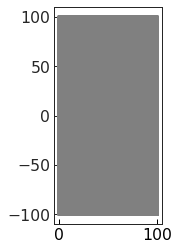

In [7]:
msh_to_xdmf("Mesh.msh", dimensions=(0, 2), directory=".")

mesh, boundaries, subdomains, labels = import_mesh(
    "Mesh",
    directory=".",
    subdomains=True,
)
dolfin.plot(mesh)
plt.show()


# Setup EM problem

Finally, instantiate the em solver

In [8]:
em_solver = FemMagnetostatic2d(mesh, boundaries, 3)


Define source term (coil current distribution) for the fem problem

In [9]:
Ic = 1e6
jc = Ic / coil.area
markers = [labels["coil"]]
functions = [jc]
jtot = ScalarSubFunc(functions, markers, subdomains)


plot the source term
Note: depending on the geometric dimension of the coil, enclosure, and mesh
characteristic length, the plot could be not so "explanatory".

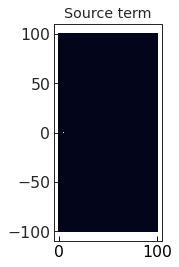

In [10]:
f_space = dolfin.FunctionSpace(mesh, "DG", 0)
f = dolfin.Function(f_space)
f.interpolate(jtot)
dolfin.plot(f, title="Source term")
plt.show()


solve the em problem and calculate the magnetic field B

In [11]:
em_solver.solve(jtot)
em_solver.calculate_b()

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2)), 51)


Compare the obtained B with both the theoretical value

1) Along the z axis (analytical solution)

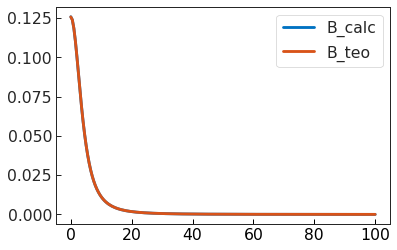

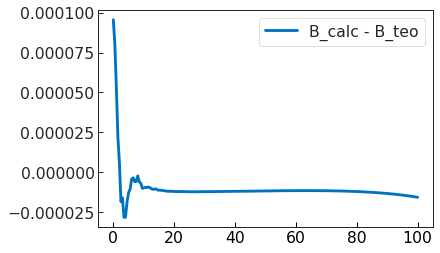

In [12]:
z_points_axis = np.linspace(0, r_enclo, 200)
r_points_axis = np.zeros(z_points_axis.shape)
Bz_axis = np.array(
    [em_solver.B(x) for x in np.array([r_points_axis, z_points_axis]).T]
).T[1]
B_teo = np.array([b_coil_axis(rc, 0, z, Ic) for z in z_points_axis])

fig, ax = plt.subplots()
ax.plot(z_points_axis, Bz_axis, label="B_calc")
ax.plot(z_points_axis, B_teo, label="B_teo")
plt.legend()
plt.show()

diff = Bz_axis - B_teo

fig, ax = plt.subplots()
ax.plot(z_points_axis, diff, label="B_calc - B_teo")
plt.legend()
plt.show()


1) Along a radial path at z_offset (solution from green function)

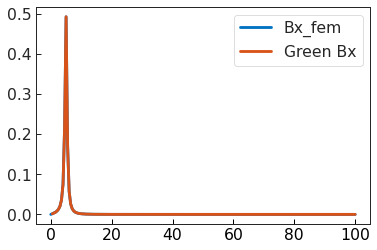

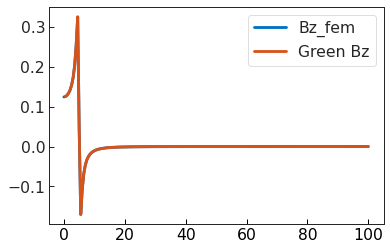

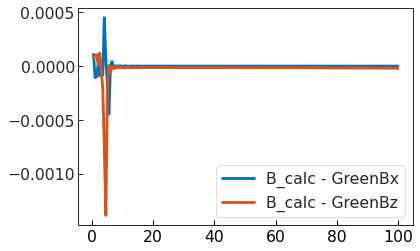

In [13]:
z_offset = 40 * drc

points_x = np.linspace(0, r_enclo, 200)
points_z = np.zeros(z_points_axis.shape) + z_offset

g_psi, g_bx, g_bz = greens.greens_all(rc, 0, points_x, points_z)
g_psi *= Ic
g_bx *= Ic
g_bz *= Ic
B_fem = np.array([em_solver.B(x) for x in np.array([points_x, points_z]).T])
Bx_fem = B_fem.T[0]
Bz_fem = B_fem.T[1]

fig, ax = plt.subplots()
ax.plot(z_points_axis, Bx_fem, label="Bx_fem")
ax.plot(z_points_axis, g_bx, label="Green Bx")
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(z_points_axis, Bz_fem, label="Bz_fem")
ax.plot(z_points_axis, g_bz, label="Green Bz")
plt.legend()
plt.show()

diff1 = Bx_fem - g_bx
diff2 = Bz_fem - g_bz

fig, ax = plt.subplots()
ax.plot(z_points_axis, diff1, label="B_calc - GreenBx")
ax.plot(z_points_axis, diff2, label="B_calc - GreenBz")
plt.legend()
plt.show()